In [39]:
'''
Import the necessary libraries to complete Exercise 8.2.
'''
import nbconvert
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats
import sklearn
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import statsmodels.api as sm
from math import sqrt
from statsmodels.tsa.holtwinters import ExponentialSmoothing as HWES
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error


import plotly.io as pio
pio.renderers.default = "notebook"
# !pip install Pyppeteer
# !pyppeteer-install

# Ignore warnings throughout the assignment.
import warnings
warnings.filterwarnings('ignore')

In [2]:
'''
Check the versions of the packages.
'''
print('numpy version:', np.__version__)
print('pandas version:', pd.__version__)
print('seaborn version:', sns.__version__)
print('matplotlib version:', matplotlib.__version__)
print('sklearn:', sklearn.__version__)

numpy version: 1.20.3
pandas version: 1.3.4
seaborn version: 0.11.2
matplotlib version: 3.4.3
sklearn: 0.24.2


In [3]:
'''
Import the dataset.
Note: A copy of the CSV file was placed into the same directory as this notebook.
Utilize pd.read_csv() to read the file as a pandas data frame.
'''
df = pd.read_csv('us_retail_sales.csv')

In [4]:
'''
Use head() function to display the first 10 rows of data of df.
'''
df.head(10)

YEAR     JAN     FEB     MAR     APR     MAY     JUN       JUL       AUG  \
0  1992  146925  147223  146805  148032  149010  149800  150761.0  151067.0   
1  1993  157555  156266  154752  158979  160605  160127  162816.0  162506.0   
2  1994  167518  169649  172766  173106  172329  174241  174781.0  177295.0   
3  1995  182413  179488  181013  181686  183536  186081  185431.0  186806.0   
4  1996  189135  192266  194029  194744  196205  196136  196187.0  196218.0   
5  1997  202371  204286  204990  203399  201699  204675  207014.0  207635.0   
6  1998  209666  209552  210832  213633  214639  216337  214841.0  213636.0   
7  1999  223997  226250  227417  229037  231235  231903  233948.0  236566.0   
8  2000  243436  247133  249825  245831  246201  248160  247176.0  247576.0   
9  2001  252654  252704  250328  254763  255218  254022  252997.0  254560.0   

        SEP       OCT       NOV       DEC  
0  152588.0  153521.0  153583.0  155614.0  
1  163258.0  164685.0  166594.0  168161.0  
2  178787.0  180561.0  180703.0  181524.0  
3  187366.0  186565.0  189055.0  190774.0  
4  198859.0  200509.0  200174.0  201284.0  
5  208326.0  208078.0  208936.0  209363.0  
6  215720.0  219483.0  221134.0  223179.0  
7  237481.0  237553.0  240544.0  245485.0  
8  251837.0  251221.0  250331.0  250658.0  
9  249845.0  267999.0  260514.0  256549.0

In [5]:
'''
Understand the shape of the dataset.
'''
print('There are {} rows and {} columns in this dataset.'.format(df.shape[0], df.shape[1]))

There are 30 rows and 13 columns in this dataset.


In [6]:
'''
Display the total size of this dataset.
'''
print('This dataset contains {} records.'.format(df.size))

This dataset contains 390 records.


In [7]:
'''
Understand if there are any missing values in the dataset.
'''
df.isna().sum().sort_values(ascending = False)

JUL     1
AUG     1
SEP     1
OCT     1
NOV     1
DEC     1
YEAR    0
JAN     0
FEB     0
MAR     0
APR     0
MAY     0
JUN     0
dtype: int64

In [8]:
'''
Understand how many missing values are in the dataset initially.
'''
df.isna().sum().sum()

6

In [9]:
'''
Summarize the findings above with info().
'''
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30 entries, 0 to 29
Data columns (total 13 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   YEAR    30 non-null     int64  
 1   JAN     30 non-null     int64  
 2   FEB     30 non-null     int64  
 3   MAR     30 non-null     int64  
 4   APR     30 non-null     int64  
 5   MAY     30 non-null     int64  
 6   JUN     30 non-null     int64  
 7   JUL     29 non-null     float64
 8   AUG     29 non-null     float64
 9   SEP     29 non-null     float64
 10  OCT     29 non-null     float64
 11  NOV     29 non-null     float64
 12  DEC     29 non-null     float64
dtypes: float64(6), int64(7)
memory usage: 3.2 KB


In [10]:
'''
Reshape the data so that the month and year are combined into one column.
Utilize the melt() function to transpose the MONTH features in combination with the YEAR column.
Remove any extra columns that are not needed for the dataframe.
Code help from DSC 630 Teams post from classmate for Week 8 Discussions.
'''
df = pd.melt(df, id_vars=['YEAR'], var_name=['MONTH'])
df['DATE'] = pd.to_datetime(df['YEAR'].astype(str) + '-' + df['MONTH'].astype(str))
df = df.sort_values(by=['DATE']).drop(columns=['MONTH', 'YEAR']).reset_index(drop=['index'])

In [11]:
'''
Rename the columns as 'sales' and 'date' for convenience for the remainder of the analysis.
'''
df.columns = ['sales', 'date']
df.head()

sales       date
0  146925.0 1992-01-01
1  147223.0 1992-02-01
2  146805.0 1992-03-01
3  148032.0 1992-04-01
4  149010.0 1992-05-01

In [12]:
'''
Show an output of the dataframe at the revised state.
'''
df = df[['date', 'sales']]
df.head()

date     sales
0 1992-01-01  146925.0
1 1992-02-01  147223.0
2 1992-03-01  146805.0
3 1992-04-01  148032.0
4 1992-05-01  149010.0

In [13]:
'''
There are missing data values for several months. Show the missing values present.
'''
df[df.isna().any(axis=1)]

date  sales
354 2021-07-01    NaN
355 2021-08-01    NaN
356 2021-09-01    NaN
357 2021-10-01    NaN
358 2021-11-01    NaN
359 2021-12-01    NaN

In [14]:
'''
Handle the missing values by removing the missing records from the dataset.
'''
df = df.dropna()

In [15]:
'''
Convert the 'sales' data to integers.
'''
df['sales'] = df['sales'].astype('int')

In [16]:
'''
Show there are no additional missing values and all features are integer data types.
'''
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 354 entries, 0 to 353
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    354 non-null    datetime64[ns]
 1   sales   354 non-null    int32         
dtypes: datetime64[ns](1), int32(1)
memory usage: 6.9 KB


In [17]:
'''
One more check showing there are no additional values missing with the revised data.
'''
df.isna().sum().sum()

0

In [18]:
'''
Set the index for the pandas dataframe using the date column.
'''
df.set_index('date', inplace = True)

In [19]:
'''
Show the first five rows of the preliminarily cleaned data.
'''
df.head()

sales
date              
1992-01-01  146925
1992-02-01  147223
1992-03-01  146805
1992-04-01  148032
1992-05-01  149010

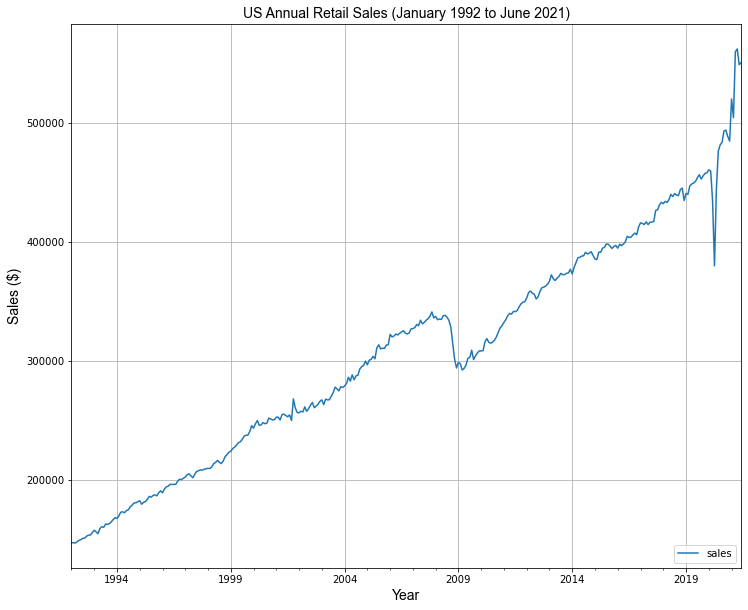

In [20]:
'''
Utilize the plot() function to construct a line plot of the US Retail Sales with respect to each year form 01/1992 to 06/2021. 
'''
plt.rcParams["figure.figsize"] = 12, 10
df.plot(grid = 'on')
plt.xlabel("Year", fontsize = 14, family = 'Arial')
plt.ylabel("Sales ($)", fontsize = 14, family = 'Arial')
plt.title('US Annual Retail Sales (January 1992 to June 2021)', family = 'Arial', fontsize = 14)
plt.legend(loc = 'lower right')
plt.show()

In [21]:
'''
Use decomposition to figure out observed, trends, seasonal, and residual insights for the retail sales data. (additive)
'''
decomposition_additive = sm.tsa.seasonal_decompose(df['sales'], model = 'additive')

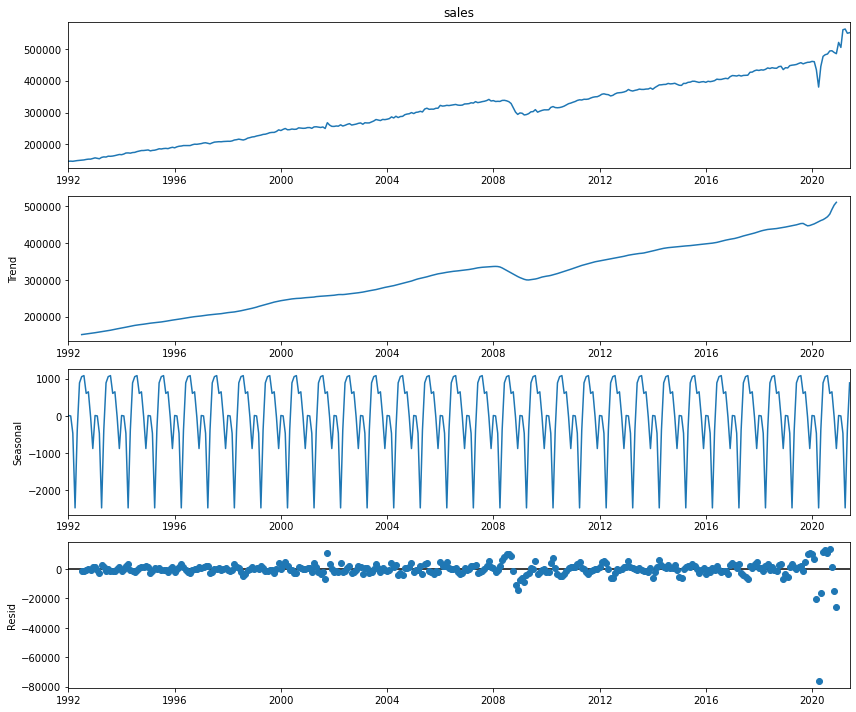

In [22]:
'''
Plot the decomposition of the data that was stored above. (additive)
'''
fig = decomposition_additive.plot()

In [23]:
'''
Use decomposition to figure out observed, trends, seasonal, and residual insights for the retail sales data. (multiply)
'''
decomposition_multiply = sm.tsa.seasonal_decompose(df['sales'], model = 'multiply')

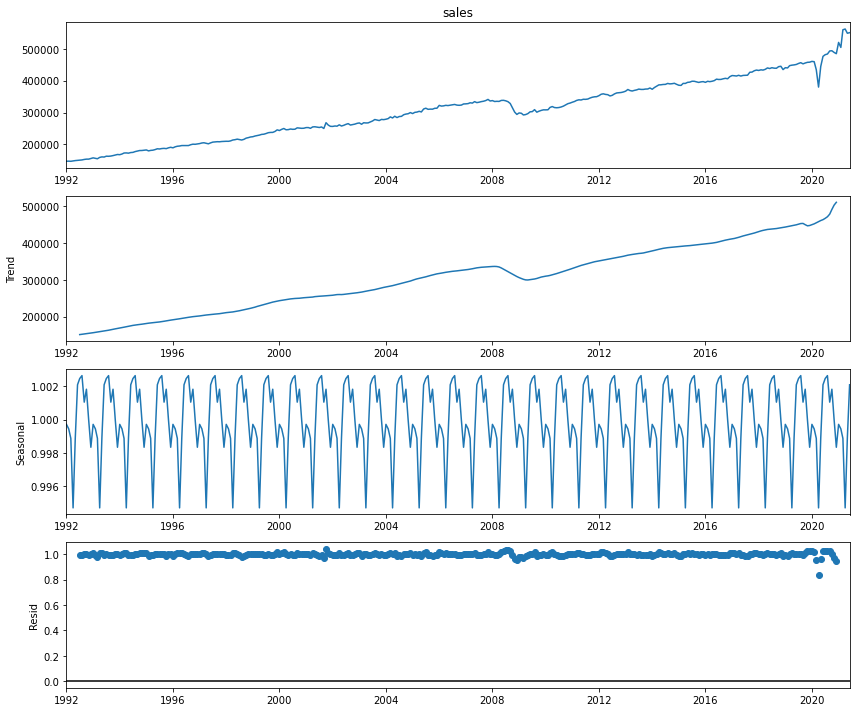

In [24]:
'''
Plot the decomposition of the data that was stored above. (multiply)
'''
fig = decomposition_multiply.plot()

In [26]:
'''
Split the data into training and test data sets. 
As specified for the assignment, the training set will be prior to July 2020.
Test data will be from July 2020 through June 2021.
'''
df_train = df.iloc[:-12]
df_test = df.iloc[-12:]

In [27]:
'''
Utilize the training data to build a Holt-Winters Forecast with Exponential Smoothing model. 
'''
hw_model = HWES(df_train, seasonal_periods=4, trend='mul', seasonal = 'add', freq = 'MS')

In [28]:
'''
Fit the hw model that was just constructed.
'''
fit_model = hw_model.fit(optimized = True, use_brute = True)

In [30]:
'''
Show the summary of the model. 
'''
print(fit_model.summary())

                       ExponentialSmoothing Model Results                       
Dep. Variable:                    sales   No. Observations:                  342
Model:             ExponentialSmoothing   SSE                    12078587621.229
Optimized:                         True   AIC                           5959.922
Trend:                   Multiplicative   BIC                           5990.601
Seasonal:                      Additive   AICC                          5960.587
Seasonal Periods:                     4   Date:                 Sun, 23 Oct 2022
Box-Cox:                          False   Time:                         07:59:07
Box-Cox Coeff.:                    None                                         
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               0.8889286                alpha                 True
smoothing_trend          

In [34]:
'''
Create a forecast for the last year of data.
'''
forecast_sales = fit_model.forecast(steps = 12)

In [35]:
'''
Convert the predicted values into a DataFrame.
Label the predicted values as 'predicted_sales'.
Convert the predicted values to integer datatypes.
Show the forecasted sales.
'''
forecast_sales_df = pd.DataFrame(forecast_sales)
forecast_sales_df.columns = ['predicted_sales']
forecast_sales_df['predicted_sales'] = forecast_sales_df['predicted_sales'].astype('int')
forecast_sales_df

predicted_sales
2020-07-01           473597
2020-08-01           474333
2020-09-01           479110
2020-10-01           479641
2020-11-01           481087
2020-12-01           481845
2021-01-01           486644
2021-02-01           487197
2021-03-01           488666
2021-04-01           489447
2021-05-01           494268
2021-06-01           494844

In [36]:
'''
Add the original_sales values from the last year to the forecast_sales_df.
'''
forecast_sales_df['original_sales'] = df_test
forecast_sales_df

predicted_sales  original_sales
2020-07-01           473597          481627
2020-08-01           474333          483716
2020-09-01           479110          493327
2020-10-01           479641          493991
2020-11-01           481087          488652
2020-12-01           481845          484782
2021-01-01           486644          520162
2021-02-01           487197          504458
2021-03-01           488666          559871
2021-04-01           489447          562269
2021-05-01           494268          548987
2021-06-01           494844          550782

In [37]:
'''
Calcualte RMSE using mean_squared_error() from sklearn.metrics.
'''
rmse = sqrt(mean_squared_error(df_test['sales'],forecast_sales_df['predicted_sales']))
print('RMSE:{}'.format(round(rmse,2)))

RMSE:10662.93


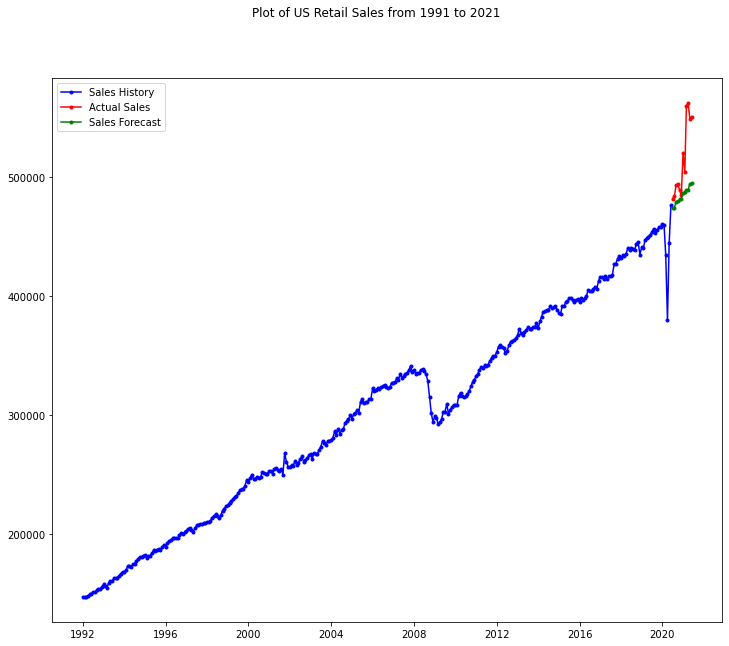

In [38]:
fig = plt.figure()
fig.suptitle('Plot of US Retail Sales from 1991 to 2021')
past, = plt.plot(df_train.index, df_train, 'b.-',label = 'Sales History')
future, = plt.plot(df_test.index, df_test, 'r.-', label = 'Actual Sales')
predicted_future, = plt.plot(df_test.index, forecast_sales, 'g.-', label = 'Sales Forecast')
plt.legend(handles=[past, future, predicted_future])
plt.show()

In [40]:
jupyter nbconvert --towebpdf--

SyntaxError: invalid syntax (Temp/ipykernel_27048/3838455249.py, line 1)